# Convolutional Neural Network

In [1]:
%matplotlib inline

In [2]:
import itertools
import matplotlib.pyplot as plt
import h5py
import numpy as np
import sklearn.preprocessing
import sklearn.metrics
import imblearn.over_sampling
import tensorflow as tf
import tensorflow.contrib.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import itertools
import spectraldl.plot as plot

Using TensorFlow backend.


In [4]:
N_CLASSES = 3

In [5]:
with h5py.File('data/data.hdf5') as f:
    X_tr_orig = f['X_tr'][...]
    y_tr_orig = f['y_tr'][...]
    X_val_orig = f['X_val'][...]
    y_val = f['y_val'][...]

In [6]:
def balancing(X, y):
    smote = imblearn.over_sampling.SMOTE()
    for i in range(N_CLASSES - 1):
        X, y = smote.fit_sample(X, y)
    return X, y

def sample_scaling(X_tr, X_val):
    X_tr = sklearn.preprocessing.minmax_scale(X_tr, axis=1)
    X_val = sklearn.preprocessing.minmax_scale(X_val, axis=1)
    return X_tr, X_val

def feature_scaling(X_tr, X_val):
    scaler = sklearn.preprocessing.MinMaxScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_val = scaler.transform(X_val)
    return X_tr, X_val

In [7]:
# create a model
model = Sequential([
    Dense(units=512, activation='relu', input_dim=X_tr_orig.shape[-1]),
    Dropout(0.5),
    Dense(units=256, activation='relu'),
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=32, activation='relu'),
    Dropout(0.5),
    Dense(units=N_CLASSES, activation='softmax'),
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [8]:
def plot_result(hist):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(hist.epoch, hist.history['acc'], label='training data')
    ax1.plot(hist.epoch, hist.history['val_acc'], label='validation data')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend()

    ax2.plot(hist.epoch, hist.history['loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')

    plt.show()

In [9]:
def show_cm(X_val, y_val):
    y_out = model.predict_classes(X_val, verbose=0)
    cm = sklearn.metrics.confusion_matrix(y_val, y_out)
    plot.plot_confusion_matrix(cm, ['emission', 'absorption', 'double-peak'], normalize=True)
    plt.show()

processing combination: ()
training accuracy: 0.869121751407 validation accuracy: 0.823100042835


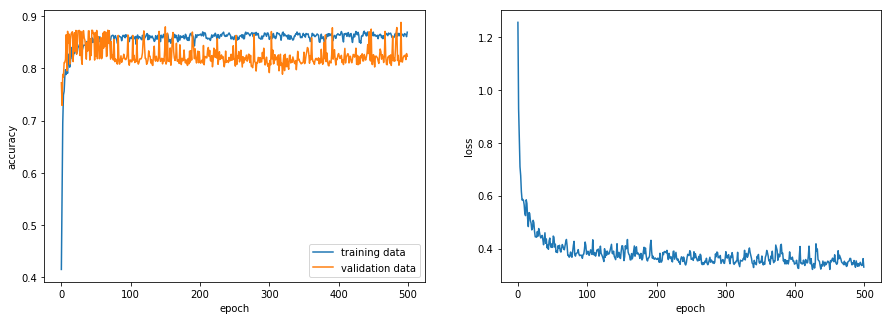

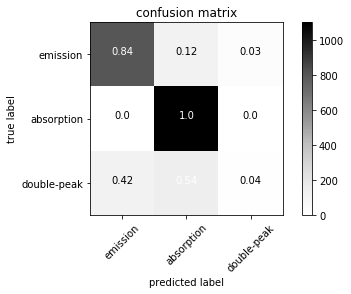

processing combination: ('balancing',)


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


training accuracy: 0.80355110388 validation accuracy: 0.838127951629


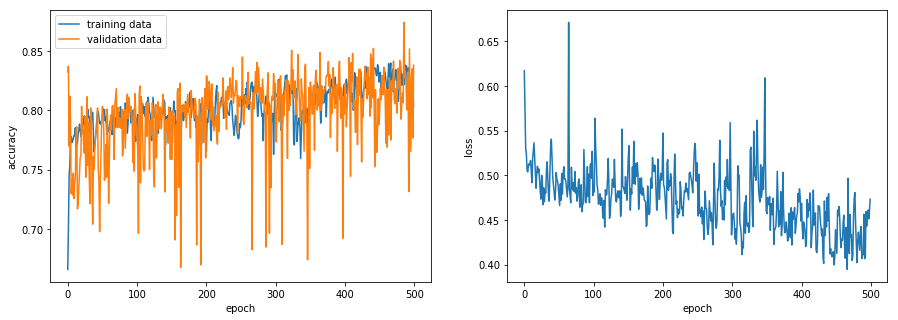

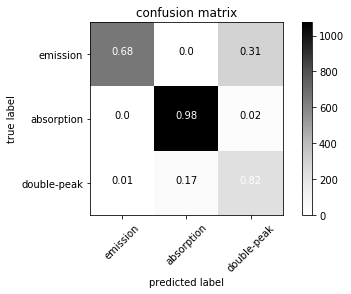

processing combination: ('sample_scaling',)
training accuracy: 0.949967789271 validation accuracy: 0.949334478087


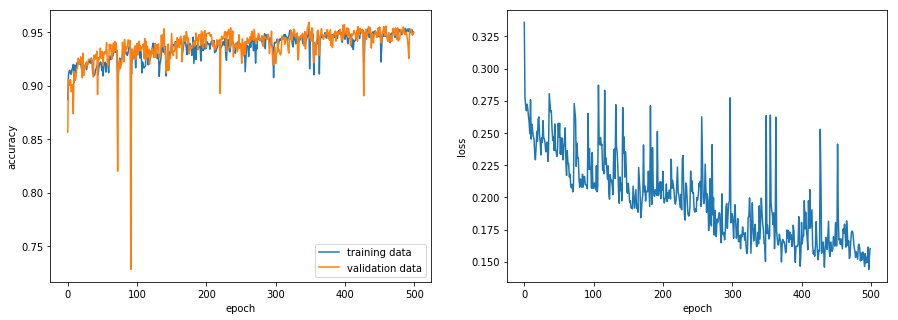

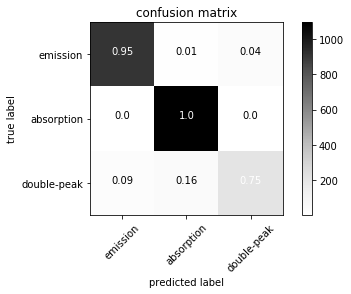

processing combination: ('feature_scaling',)
training accuracy: 0.820055829601 validation accuracy: 0.760412194382


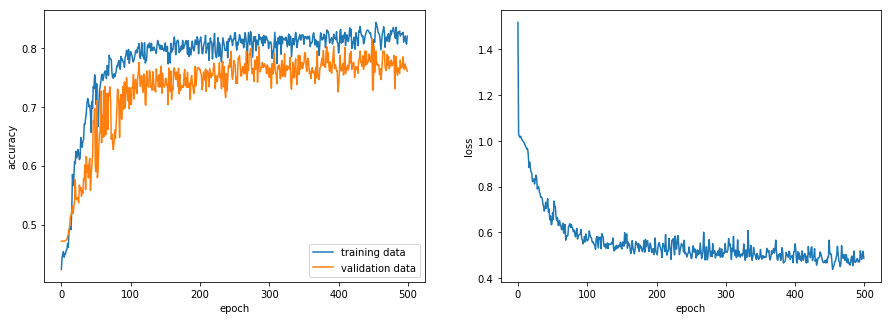

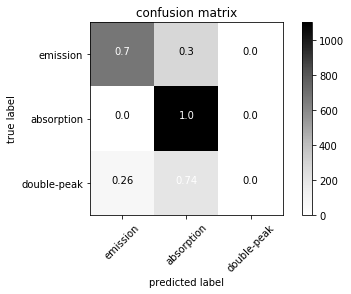

processing combination: ('balancing', 'sample_scaling')


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


training accuracy: 0.935579330559 validation accuracy: 0.961356805496


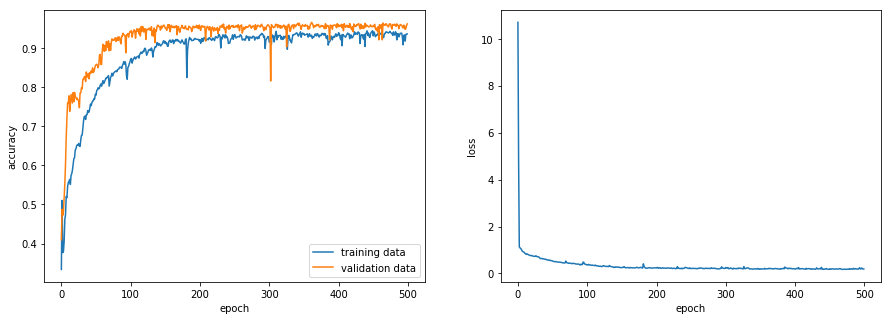

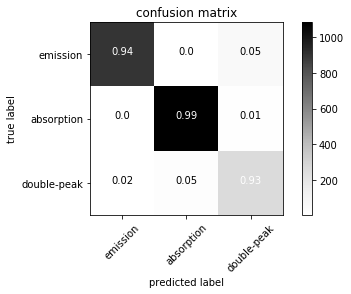

processing combination: ('balancing', 'feature_scaling')


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


training accuracy: 0.674558008728 validation accuracy: 0.612279948361


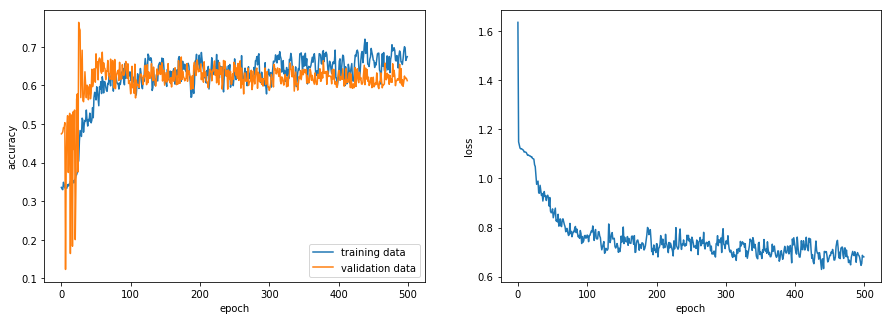

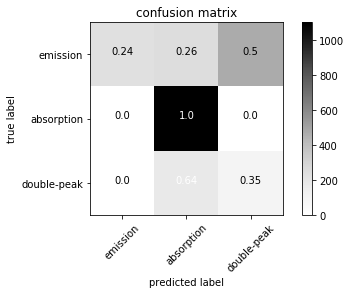

processing combination: ('sample_scaling', 'feature_scaling')
training accuracy: 0.948035214806 validation accuracy: 0.951481321995


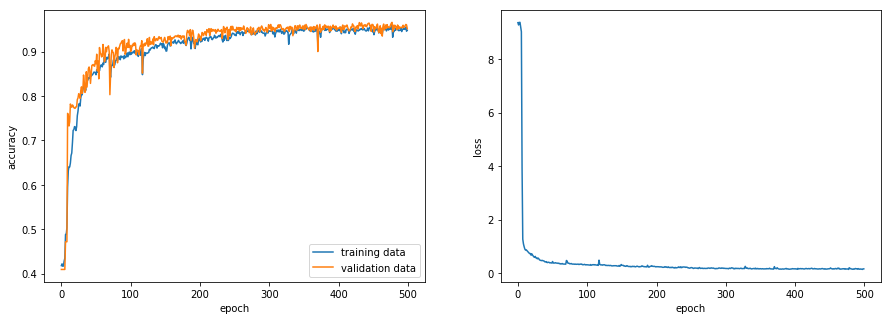

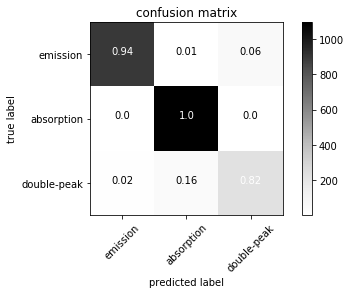

processing combination: ('balancing', 'sample_scaling', 'feature_scaling')


/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


training accuracy: 0.947719857082 validation accuracy: 0.957492485815


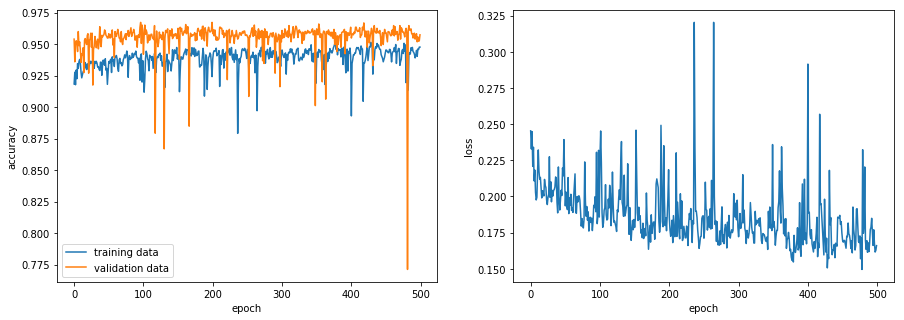

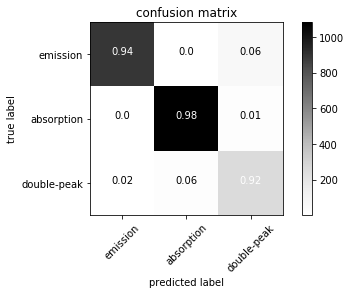

In [10]:
xs = ['balancing', 'sample_scaling', 'feature_scaling']

result = {}
for length in range(len(xs) + 1):
    for x in itertools.combinations(xs, r=length):
        print('processing combination:', x)
        # get original data
        X_tr = np.copy(X_tr_orig)
        y_tr = np.copy(y_tr_orig)
        X_val = np.copy(X_val_orig)
        
        # preprocessing
        if 'balancing' in x:
            X_tr, y_tr = balancing(X_tr, y_tr)
        if 'sample_scaling' in x:
            X_tr, X_val = sample_scaling(X_tr, X_val)
        if 'feature_scaling' in x:
            X_tr, X_val = feature_scaling(X_tr, X_val)

        y_oh_tr = keras.utils.to_categorical(y_tr, num_classes=N_CLASSES)
        y_oh_val = keras.utils.to_categorical(y_val, num_classes=N_CLASSES)

        # fit the model
        hist = model.fit(
            X_tr, y_oh_tr,
            epochs=500, batch_size=256, verbose=0,
            validation_data=(X_val, y_oh_val)
        )
        
        print(
            'training accuracy:', hist.history['acc'][-1],
            'validation accuracy:', hist.history['val_acc'][-1]
        )
        plot_result(hist)
        show_cm(X_val, y_val)
        result[x] = hist